<a href="https://colab.research.google.com/github/adelardw/WeatherClassification/blob/main/W3_5CL_CNN_M1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import nn
from torchvision.transforms.functional import pil_to_tensor,resize
from torchvision.transforms import Compose,PILToTensor, ConvertImageDtype,Resize,RandomAffine,RandomHorizontalFlip,RandomEqualize,RandomVerticalFlip


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"fullnamecorrection","key":"04174ef12a2ae4fe42e99083eb4777b2"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vijaygiitk/multiclass-weather-dataset

 96% 129M/134M [00:05<00:00, 25.8MB/s]
100% 134M/134M [00:05<00:00, 26.8MB/s]


In [4]:
!unzip /content/multiclass-weather-dataset.zip

Archive:  /content/multiclass-weather-dataset.zip
  inflating: dataset/alien_test/Cloud_1.png  
  inflating: dataset/alien_test/Cloud_2.jpg  
  inflating: dataset/alien_test/Cloud_3.jpeg  
  inflating: dataset/alien_test/Cloud_4.jpg  
  inflating: dataset/alien_test/foggy_1.jpg  
  inflating: dataset/alien_test/foggy_10.jpg  
  inflating: dataset/alien_test/foggy_2.jpg  
  inflating: dataset/alien_test/foggy_3.jpg  
  inflating: dataset/alien_test/foggy_4.jpg  
  inflating: dataset/alien_test/foggy_5.jpg  
  inflating: dataset/alien_test/foggy_6.jpg  
  inflating: dataset/alien_test/foggy_7.jpg  
  inflating: dataset/alien_test/foggy_8.jpg  
  inflating: dataset/alien_test/foggy_9.jpg  
  inflating: dataset/alien_test/rain_1.jpg  
  inflating: dataset/alien_test/rain_2.png  
  inflating: dataset/alien_test/rain_3.jpg  
  inflating: dataset/alien_test/rain_4.jpg  
  inflating: dataset/alien_test/rain_5.jpg  
  inflating: dataset/alien_test/rain_6.jpg  
  inflating: dataset/alien_test/sh

In [5]:
device = 'cuda:0'
batch_s = 75

In [6]:
import shutil
shutil.rmtree("/content/dataset/alien_test") #delete test folder

In [7]:
class MyDATA:

  def __init__(self, link_on_dataset):
    self.link_on_dataset = link_on_dataset

  def data_means(self):

    init_fst = torchvision.datasets.ImageFolder(self.link_on_dataset,
                                                transform = PILToTensor())

    print('Images channels ',init_fst.__getitem__(0)[0].shape[0])
    n = init_fst.__len__()
    h,w = 0, 0
    for i in range(n):
      h += init_fst.__getitem__(i)[0].shape[1]
      w += init_fst.__getitem__(i)[0].shape[2]
    print('Average images size: h, w: \n',int(h/n),int(w/n))
    return int(h/n),int(w/n)

  def find_images_weights(self,train_size_ = 0.8):

    data = torchvision.datasets.ImageFolder(self.link_on_dataset)
    total_count = len(data )
    train_count = int(train_size_ * total_count)
    test_count = total_count - train_count
    train_data, test_data = torch.utils.data.random_split(data, (train_count, test_count))
    print('Total len \n', total_count)

    my_gen = ( data.samples[i][1] for i in range(train_count) )
    elements_in_classes = {}

    for val in my_gen:
      if val not in elements_in_classes:
        elements_in_classes[val] = 1
      else:
        elements_in_classes[val] += 1

    print('Num of elements in each classes\n' ,
          data.class_to_idx,'\n',
          elements_in_classes)

    num_classes =  elements_in_classes.__len__()
    weight_per_class = [0.] *num_classes
    for i in range( num_classes):
      weight_per_class[i]= train_count/elements_in_classes[i]

    weight = [0.] * train_count
    for idx, val in enumerate(train_data):
        weight[idx] = weight_per_class[val[1]]

    return weight


  def data_loader_and_TTsplit(self,batch_size_ = 10,train_size = 0.8, sampler_ = None, transform_parameters = None):
    resizer = MyDATA(self.link_on_dataset).data_means()

    basic_transform = Compose([
    Resize(resizer),
    PILToTensor(),
    ConvertImageDtype(torch.float32)])

    if sampler_  is not None:
      weights =  MyDATA(self.link_on_dataset).find_images_weights(train_size_ = train_size)
      weights = torch.DoubleTensor(weights)
      sampler_ = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
    else:
      shufler = True

    if transform_parameters is None:
      result = torchvision.datasets.ImageFolder(self.link_on_dataset, transform = basic_transform)
      total_count = len(result)
      train_count = int(train_size * total_count)
      test_count = total_count - train_count
      train_data, test_data = torch.utils.data.random_split(result, (train_count, test_count),
                                                            generator = torch.Generator().manual_seed(42))

      train_data_loader = torch.utils.data.DataLoader(train_data,
                                                      batch_size = batch_size_,
                                                      shuffle = shufler,
                                                      sampler = sampler_ ,
                                                      num_workers=2)

      test_data_loader = torch.utils.data.DataLoader(test_data,
                                                     batch_size = batch_size_,
                                                     shuffle=False,
                                                     num_workers=2)

      return train_data_loader, test_data_loader

    else:
      dataset_1 = torchvision.datasets.ImageFolder(self.link_on_dataset,
                                             transform = basic_transform)

      dataset_2 =torchvision.datasets.ImageFolder(self.link_on_dataset,
                                             transform = transform_parameters)


      result = torch.utils.data.ConcatDataset((dataset_1,dataset_2))

      total_count = len(result)
      train_count = int(train_size * total_count)
      test_count = total_count - train_count

      train_data, test_data = torch.utils.data.random_split(result, (train_count, test_count),
                                                            generator = torch.Generator().manual_seed(42))

      train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size = batch_size_,
                                                shuffle = shufler,
                                                sampler = sampler_,
                                                num_workers=2)


      test_data_loader = torch.utils.data.DataLoader(test_data,
                                               batch_size = batch_size_,
                                               shuffle=False,
                                               num_workers=2)
      return train_data_loader, test_data_loader





In [8]:
transforms_two = Compose([
  RandomAffine(degrees=(30, 50), translate=(0.1, 0.3), scale=(0.5, 0.75)),
  Resize((334, 506)),
  PILToTensor(),
  RandomHorizontalFlip() ,
  RandomVerticalFlip(),
  RandomEqualize(),
  ConvertImageDtype(torch.float16),

])

In [9]:
new = MyDATA('/content/dataset')

train_data_loader, test_data_loader = new.data_loader_and_TTsplit(batch_size_ = batch_s  )


Images channels  3
Average images size: h, w: 
 412 591


In [10]:
train_data_loader.dataset.dataset.class_to_idx

{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}

In [ ]:
# model_ 3 - better
'''
model = nn.Sequential(
    nn.Conv2d(in_channels = 3 , out_channels = 128, kernel_size = (16, 16)),
    nn.CELU(alpha = 2),
    nn.MaxPool2d((4,4)),


    nn.Conv2d(in_channels = 128 , out_channels = 256, kernel_size  = (16,16)),
    nn.CELU(alpha = 2),
    nn.MaxPool2d((4,4)),
    nn.BatchNorm2d(num_features = 256),

    nn.Conv2d(in_channels = 256 , out_channels = 128, kernel_size  = (8,8)),
    nn.CELU(),
    nn.MaxPool2d((4,4)),


    nn.Flatten(),
    nn.ReLU(),
    nn.Linear(in_features = 1024 ,out_features = 128),
    nn.ReLU(),
    nn.Linear(in_features = 128, out_features = 64),
    nn.ReLU(),
    nn.Linear(in_features = 64,out_features = 32),
    nn.ReLU(),
    nn.Linear(in_features = 32,out_features = 16),
    nn.Linear(in_features = 16,out_features = 4),





).to(device)
'''

In [11]:
model = nn.Sequential(
    nn.Conv2d(in_channels = 3 , out_channels = 64, kernel_size = (32, 32)),
    nn.SiLU(),
    nn.MaxPool2d((4,4)),


    nn.Conv2d(in_channels = 64 , out_channels = 128, kernel_size  = (16,16)),
    nn.SiLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(num_features = 128),

    nn.Conv2d(in_channels = 128 , out_channels = 64, kernel_size  = (16,16)),
    nn.SiLU(),
    nn.MaxPool2d((2,2)),

    nn.Conv2d(in_channels = 64 , out_channels = 32, kernel_size  = (4,4)),
    nn.SiLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(num_features = 32),


    nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size  = (2,2)),
    nn.SiLU(),
    nn.MaxPool2d((2,2)),
    nn.BatchNorm2d(num_features = 16),


    nn.Flatten(),
    nn.LeakyReLU(),
    nn.Linear(in_features = 64 ,out_features = 64),
    nn.LeakyReLU(),
    nn.Linear(in_features = 64, out_features = 32),
    nn.LeakyReLU(),
    nn.Linear(in_features = 32,out_features = 16),
    nn.LeakyReLU(),
    nn.Linear(in_features = 16,out_features = 8),
    nn.Linear(in_features = 8,out_features = 5),





).to(device)

In [12]:
from torchsummary import summary
summary(model, input_size= (3, 412, 591))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 381, 560]         196,672
              SiLU-2         [-1, 64, 381, 560]               0
         MaxPool2d-3          [-1, 64, 95, 140]               0
            Conv2d-4         [-1, 128, 80, 125]       2,097,280
              SiLU-5         [-1, 128, 80, 125]               0
         MaxPool2d-6          [-1, 128, 40, 62]               0
       BatchNorm2d-7          [-1, 128, 40, 62]             256
            Conv2d-8           [-1, 64, 25, 47]       2,097,216
              SiLU-9           [-1, 64, 25, 47]               0
        MaxPool2d-10           [-1, 64, 12, 23]               0
           Conv2d-11            [-1, 32, 9, 20]          32,800
             SiLU-12            [-1, 32, 9, 20]               0
        MaxPool2d-13            [-1, 32, 4, 10]               0
      BatchNorm2d-14            [-1, 32

In [13]:
from torch import optim
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.NAdam(model.parameters(), lr=0.001, weight_decay=0.0001)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [ ]:
# if GPU is fully, drop it
torch.cuda.empty_cache()

In [14]:
class TrainProcess:

  def __init__(self, train_data, test_data):
    self.train_data = train_data
    self.test_data = test_data

  def train_proc(self, model, optimiser, loss_function):
    size_train = self.train_data.dataset.__len__()
    train_loss = 0
    num_batches = len(self.train_data)
    for batch, (X, y) in enumerate(self.train_data):
        X = X.to(device).to(torch.float32)
        y = y.to(device)

        pred = model(X)
        loss = loss_function(pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size_train:>5d}]")
    train_loss /= num_batches
    return train_loss

  def test_proc(self, model, loss_func):
    size_test = self.test_data.dataset.__len__()
    num_batches = len(self.test_data)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in self.test_data:
            X = X.to(device).to(torch.float32)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_func(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size_test
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

  def lets_do_this(self, model_,loss_funct, optim, epochs = 12, plt_curve = True):
    train_loss_history = []
    test_loss_history = []
    try:
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loss = TrainProcess(self.train_data,self.test_data).train_proc(model_, optim, loss_funct,)
            train_loss_history.append(train_loss)


            test_loss = TrainProcess(self.train_data,self.test_data).test_proc(model_, loss_funct)
            test_loss_history.append(test_loss)
    except: KeyboardInterrupt
    print("Done!")
    if plt_curve == True:
      n_epochs = len(train_loss_history)
      plt.plot(np.arange(0, n_epochs), train_loss_history, label='train loss')
      plt.plot(np.arange(0, n_epochs), test_loss_history, label='test loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title('Loss curve')
      plt.legend()
      return train_loss_history, test_loss_history
    else:
      return train_loss_history, test_loss_history




Epoch 1
-------------------------------
loss: 1.639860  [   75/ 1200]
loss: 1.571613  [  825/ 1200]
Test Error: 
 Accuracy: 38.7%, Avg loss: 1.520963 

Epoch 2
-------------------------------
loss: 1.505950  [   75/ 1200]
loss: 1.351504  [  825/ 1200]
Test Error: 
 Accuracy: 38.0%, Avg loss: 1.361867 

Epoch 3
-------------------------------
loss: 1.385801  [   75/ 1200]
loss: 1.292554  [  825/ 1200]
Test Error: 
 Accuracy: 47.3%, Avg loss: 1.153069 

Epoch 4
-------------------------------
loss: 1.217956  [   75/ 1200]
loss: 1.127516  [  825/ 1200]
Test Error: 
 Accuracy: 52.0%, Avg loss: 1.059335 

Epoch 5
-------------------------------
loss: 1.007534  [   75/ 1200]
loss: 0.999284  [  825/ 1200]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.966696 

Epoch 6
-------------------------------
loss: 1.157501  [   75/ 1200]
loss: 0.975171  [  825/ 1200]
Test Error: 
 Accuracy: 60.0%, Avg loss: 0.880962 

Epoch 7
-------------------------------
loss: 0.812751  [   75/ 1200]
loss: 0.887747  [ 

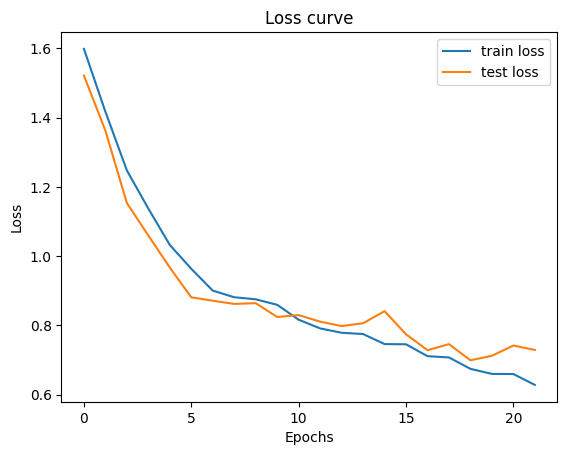

In [15]:
initilize = TrainProcess(train_data_loader, test_data_loader)
tr_C, te_C = initilize.lets_do_this(model_ = model,loss_funct = criterion,optim = optimizer,epochs = 30)

In [16]:
# add gdrive that download model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# use it to save model
torch.save(model,'/content/drive/MyDrive/W3/M1_80acc_by_20epoch')


In [ ]:
# download your model parameters
model = torch.load('/content/drive/MyDrive/weather_1:cnn/HEAVY_model')

In [ ]:
import cv2

image = cv2.imread('/content/r1.jpg')
dim = (334, 506)

resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
our = torch.Tensor(resized).to(torch.float32).to(device)
good_model = our.transpose(0,2).unsqueeze(0)

In [ ]:
''' class ti idx'''
'''{'Cloudy': 0, 'Rain': 1, 'Shine': 2, 'Sunrise': 3}'''

In [ ]:
model(good_model).argmax()

tensor(3, device='cuda:0')